In [ ]:
!pip install underthesea

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 71.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 993.5/993.5 kB 67.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 64.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re,string
from underthesea import word_tokenize
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from typing import Iterable, List
from gensim.models import KeyedVectors
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
from torch.nn.utils.rnn import pad_sequence
from timeit import default_timer as timer
import math
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Use 170000 samples of dataset for training model and 30000 samples left for testing model

In [ ]:
en_sents = open(r"/content/drive/MyDrive/dataset/en_sents", encoding = 'UTF-8').read().splitlines()
vi_sents = open(r"/content/drive/MyDrive/dataset/vi_sents", encoding = 'UTF-8').read().splitlines()
raw_data = {
        "en": [line for line in en_sents[:170000]], # Only take first 170000 lines
        "vi": [line for line in vi_sents[:170000]],
    }
df = pd.DataFrame(raw_data, columns=["en", "vi"])
print(len(en_sents))
df.head()

254090


,en,vi
0,Please put the dustpan in the broom closet,xin vui lòng đặt người quét rác trong tủ chổi
1,Be quiet for a moment.,im lặng một lát
2,Read this,đọc này
3,Tom persuaded the store manager to give him ba...,tom thuyết phục người quản lý cửa hàng trả lại...
4,Friendship consists of mutual understanding,tình bạn bao gồm sự hiểu biết lẫn nhau


This dataset provides a set of 254,090 tuples containing an English source sentence, its Vietnamese human translation and we take 170000 set for training and evaluation

## Data Preprocessing

In [ ]:
df.isna().sum()

en    0
vi    0
dtype: int64

In [ ]:
def preprocessing(df):
  df["en"] = df["en"].apply(lambda ele: ele.translate(str.maketrans('', '', string.punctuation))) # Remove punctuation
  df["vi"] = df["vi"].apply(lambda ele: ele.translate(str.maketrans('', '', string.punctuation)))
  df["en"] = df["en"].apply(lambda ele: ele.lower()) # convert text to lowercase
  df["vi"] = df["vi"].apply(lambda ele: ele.lower())
  df["en"] = df["en"].apply(lambda ele: ele.strip())
  df["vi"] = df["vi"].apply(lambda ele: ele.strip())
  df["en"] = df["en"].apply(lambda ele: re.sub("\s+", " ", ele))
  df["vi"] = df["vi"].apply(lambda ele: re.sub("\s+", " ", ele))

  return df

df = preprocessing(df)
df.head()

,en,vi
0,please put the dustpan in the broom closet,xin vui lòng đặt người quét rác trong tủ chổi
1,be quiet for a moment,im lặng một lát
2,read this,đọc này
3,tom persuaded the store manager to give him ba...,tom thuyết phục người quản lý cửa hàng trả lại...
4,friendship consists of mutual understanding,tình bạn bao gồm sự hiểu biết lẫn nhau


Tokenzing for english which is source language by tokenizer of basic english and vietnamese which is target language by Underthesea library

In [ ]:
# Create source and target language tokenizer.
SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'vi'

# Place-holders
token_transform = {}
vocab_transform = {}

# Tokenize for vietnames by underthesea
def vi_tokenizer(sentence):
    tokens = word_tokenize(sentence)
    return tokens

token_transform[SRC_LANGUAGE] = get_tokenizer('basic_english')
token_transform[TGT_LANGUAGE] = get_tokenizer(vi_tokenizer)

# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    for index,data_sample in data_iter:
        yield token_transform[language](data_sample[language])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = df.iterrows()
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

## Model Defination

In [ ]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
DEVICE

device(type='cuda')

In [ ]:
# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float = 0.1,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()

        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        self.transformer = Transformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size)
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask)
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

In [ ]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

Define the parameters of the model, instantiate the same and the loss function which is the cross-entropy loss and the optmizer used for training is Adam with β1 = 0.9, β2 = 0.98 and epsilon = 1e−9.

In [ ]:
torch.manual_seed(0)
SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8 # embed_dim must be divisible by num_heads
FFN_HID_DIM = 512
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 4
NUM_DECODER_LAYERS = 4
DROP_OUT = 0.1

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM,DROP_OUT)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)

optimizer = torch.optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

Define collate function that convert batch of raw strings into batch tensors that can be fed directly into model.

In [ ]:
# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor




# function to collate data samples into batch tesors
def collate_fn(batch):
    src_batch, tgt_batch = [], []

    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

Split data to train and test set

In [ ]:
# Split data to tran test set
split_ratio = 0.9
split = round(df.shape[0]* split_ratio)
train = df.iloc[:split]
train_ds = list(zip(train['en'],train['vi']))
valid = df.iloc[split:]
val_ds = list(zip(valid['en'],valid['vi']))

Define training and evaluation loop that will be called for each epoch with Gradient accumulation which is a technique where you can train on bigger batch sizes than your machine would normally be able to fit into memory. This is done by accumulating gradients over several batches, and only stepping the optimizer after a certain number of batches have been performed.

In [ ]:
from torch.utils.data import DataLoader

accumulation_steps = 5

def train_epoch(model, optimizer):
    model.train()
    losses = 0
    val_los = 0
    train_dataloader = DataLoader(train_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)
    optimizer.zero_grad()
    for i, (src, tgt) in enumerate(train_dataloader):
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)
        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss = loss / accumulation_steps # Normalize our loss (if averaged)
        loss.backward()

        if (i+1) % accumulation_steps == 0:             # Wait for several backward steps
            optimizer.step() # Now we can do an optimizer step
            optimizer.zero_grad() # Reset gradients tensor

        losses += loss.item()

    return losses / len(train_dataloader)

def evaluate(model):
    model.eval()
    losses = 0

    #val_iter = valid.iterrows()
    val_dataloader = DataLoader(val_ds, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss = loss / accumulation_steps # Normalize our loss (if averaged)
        losses += loss.item()

    return losses / len(val_dataloader)

Define an early stopping function to avoid the model from overfit

In [ ]:
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0):

        self.tolerance = tolerance
        self.min_delta = min_delta
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_loss, validation_loss):
        if (validation_loss - train_loss) > self.min_delta:
            self.counter +=1
            if self.counter >= self.tolerance:
                self.early_stop = True

Training model

In [ ]:
early_stopping = EarlyStopping(tolerance=5, min_delta=0.1)
NUM_EPOCHS = 30
history = {
        "loss": [],
        "val_los": []
        }
BLEU_score_per_epoch = []
for epoch in range(1, NUM_EPOCHS+1):
    start_time = timer()
    train_loss = train_epoch(transformer, optimizer)
    end_time = timer()
    val_loss = evaluate(transformer)
    history['loss'].append(train_loss)
    history['val_los'].append(val_loss)
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
    # Early Stopping
    early_stopping(train_loss, val_loss)
    if early_stopping.early_stop:
        print("We are at epoch:", epoch)
        break

Epoch: 1, Train loss: 0.938, Val loss: 0.621, Epoch time = 228.047s
Epoch: 2, Train loss: 0.534, Val loss: 0.400, Epoch time = 226.426s
Epoch: 3, Train loss: 0.378, Val loss: 0.305, Epoch time = 225.808s
Epoch: 4, Train loss: 0.296, Val loss: 0.255, Epoch time = 225.641s
Epoch: 5, Train loss: 0.245, Val loss: 0.222, Epoch time = 223.991s
Epoch: 6, Train loss: 0.210, Val loss: 0.203, Epoch time = 226.925s
Epoch: 7, Train loss: 0.184, Val loss: 0.187, Epoch time = 227.356s
Epoch: 8, Train loss: 0.164, Val loss: 0.175, Epoch time = 226.604s
Epoch: 9, Train loss: 0.147, Val loss: 0.166, Epoch time = 226.021s
Epoch: 10, Train loss: 0.134, Val loss: 0.161, Epoch time = 224.801s
Epoch: 11, Train loss: 0.122, Val loss: 0.155, Epoch time = 225.321s
Epoch: 12, Train loss: 0.112, Val loss: 0.151, Epoch time = 224.413s
Epoch: 13, Train loss: 0.104, Val loss: 0.148, Epoch time = 224.866s
Epoch: 14, Train loss: 0.096, Val loss: 0.146, Epoch time = 224.054s
Epoch: 15, Train loss: 0.089, Val loss: 0.1

Traning and Validate plotting

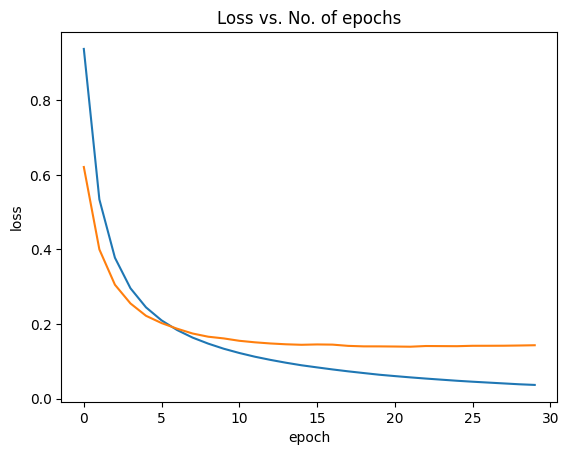

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history['loss'], label = "loss")
plt.plot(history['val_los'], label = "Val loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

**Inference**

In [ ]:
# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model, src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()

    translated_sentence = " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

    return translated_sentence


In [ ]:
# Saving model
#torch.save(transformer.state_dict(), "/content/drive/MyDrive/dataset/save_model/viEn_transformer.pth")

In [ ]:
transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM,DROP_OUT)
transformer.load_state_dict(torch.load("/content/drive/MyDrive/save_model_v2/save_model_v2/viEn_transformer.pth"))
transformer = transformer.to(DEVICE)
transformer

Seq2SeqTransformer(
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerDecoderLayer(
          (self_attn): MultiheadAttent

In [ ]:
sequence = "I love science "
translate(transformer, sequence)

' tôi yêu khoa học '

Testing model by randomly take 10 samples from the rest of the dataset and calculate BLEU score of each samples

In [ ]:
import nltk
def calculate_bleu_score(reference, translation):
    references = [reference.split()]
    hypothesis = translation.split()
    bleu_score = nltk.translate.bleu_score.sentence_bleu(references, hypothesis)

    return bleu_score

In [ ]:
from random import randint

rand = [randint(170000,200000) for i in range(100)]
test_set = [
        [en_sents[i] for i in rand],
        [vi_sents[i] for i in rand]]
total_bleu_score = 0
num_sentences = len(test_set[0])
for i in range(len(test_set[0])):
    input_sentence = test_set[0][i]
    actual_translation = test_set[1][i]
    predicted_translation = translate(transformer, input_sentence)
    print('Input English sentence:', input_sentence)
    print('Actual Vietnamese Translation:', actual_translation)
    print('Predicted Vietnamese Translation:', predicted_translation)
    bleu_score = calculate_bleu_score(actual_translation, predicted_translation)
    total_bleu_score += bleu_score
    print('BLEU Score:', bleu_score)
    print('\n')
average_bleu_score = total_bleu_score / num_sentences
print('Average BLEU Score:', average_bleu_score)

Input English sentence: I thought you said you didn't want to be disturbed.
Actual Vietnamese Translation: Tôi nghĩ bạn nói rằng bạn không muốn bị làm phiền.
Predicted Vietnamese Translation:  tôi nghĩ bạn nói rằng bạn sẽ xem tạp chí ngay cả để bị làm phiền 
BLEU Score: 0.26332019392396333


Input English sentence: These pictures are amazing.
Actual Vietnamese Translation: những hình ảnh này là tuyệt vời.
Predicted Vietnamese Translation:  những bức ảnh này được mang lại tuyệt vời 
BLEU Score: 7.241926111174567e-155


Input English sentence: I've had better days.
Actual Vietnamese Translation: Tôi đã có những ngày tốt hơn.
Predicted Vietnamese Translation:  tôi cảm thấy khác biệt về ngày mới nhất 
BLEU Score: 1.0518351895246305e-231


Input English sentence: I think we both know who's really to blame
Actual Vietnamese Translation: tôi nghĩ rằng cả hai chúng tôi đều biết ai thực sự đổ lỗi
Predicted Vietnamese Translation:  tôi nghĩ rằng cả hai chúng tôi biết một gia đình thực sự đáng tr

Evaluation: Calculate average BLEU score on test dataset

In [ ]:
from random import randint
test_data = [
        en_sents[170001:200000],
        vi_sents[170001:200000]]
total_bleu_score = 0
num_sentences = len(test_data[0])
for i in range(len(test_data[0])):
    input_sentence = test_data[0][i]
    actual_translation = test_data[1][i]
    predicted_translation = translate(transformer, input_sentence)
    bleu_score = calculate_bleu_score(actual_translation, predicted_translation)
    total_bleu_score += bleu_score
average_bleu_score = total_bleu_score / num_sentences
print('Average BLEU Score:', average_bleu_score)

Average BLEU Score: 0.32613232932309383


In [ ]:
pip install googletrans==4.0.0-rc1

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.1/55.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.4/133.4 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 9.3 MB/s eta 0:00:00
  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17397 sha256=ec419aa52cc08e3812224ce891c515285859ed50c47ca717db1d9cf7b2235ff2
  Stored in directory: /root/.cache/pip/wheels/c0/59/9f/7372f0cf70160fe61b528532e1a7c8498c4becd6bcffb022de
Successfully built googletrans
  Attempting uninstall: chardet
    Found existing installation: chardet 4.0.0
    Uninstalling ch

Calculate average BLEU score of Google Translate

In [ ]:
from googletrans import Translator, LANGUAGES
import re

def translate_text(text, dest_lang='vi'):
    try:
        translator = Translator(service_urls=['translate.google.com'])
        if not text or not re.match(r'^[\w\W]{1,5000}$', text):
            return ' '
        translated = translator.translate(text, dest=dest_lang)
        return translated.text
    except Exception as e:
        return ' '

In [ ]:
total_bleu_score = 0
test_set = [
        en_sents[170001:200000],
        vi_sents[170001:200000]]
num_sentences = len(test_set[0])
for i in range(len(test_set[0])):
  input_sentence = test_set[0][i]
  actual_translation = test_set[1][i]
  predicted_translation = translate_text(input_sentence,'vi')
  bleu_score = calculate_bleu_score(actual_translation, predicted_translation)
  total_bleu_score += bleu_score
average_bleu_score = total_bleu_score / num_sentences
print('Average BLEU Score:', average_bleu_score)

Average BLEU Score: 0.5578002860768766


In [ ]:
from random import randint

rand = [randint(170000,200000) for i in range(10)]
test_set = [
        [en_sents[i] for i in rand],
        [vi_sents[i] for i in rand]]
total_bleu_score = 0
num_sentences = len(test_set[0])
for i in range(len(test_set[0])):
    input_sentence = test_set[0][i]
    actual_translation = test_set[1][i]
    predicted_translation = translate(transformer, input_sentence)
    google_translation = translate_text(input_sentence)
    bleu_score_gg = calculate_bleu_score(actual_translation,google_translation)
    bleu_score_trans = calculate_bleu_score(actual_translation,predicted_translation)
    print('Input English sentence:', input_sentence)
    print('Actual Vietnamese Translation:', actual_translation)
    print((f"Google Translation: {google_translation}, BLEU score: {bleu_score_gg}"))
    print((f"Transformer translation: {predicted_translation}, BLEU score: {bleu_score_trans}"))
    print('\n')

Input English sentence: Why did you come back from Germany?
Actual Vietnamese Translation: tại sao bạn trở về từ Đức?
Google Translation: Tại sao bạn trở về từ Đức?, BLEU score: 0.8091067115702212
Transformer translation:  tại sao bạn trở về từ các bộ sưu tập đức , BLEU score: 0.4617366309441026


Input English sentence: She is looking forward to seeing him again
Actual Vietnamese Translation: cô đang mong được gặp lại anh
Google Translation: Cô ấy rất mong được gặp lại anh ấy, BLEU score: 0.44632361378533286
Transformer translation:  cô rất mong được gặp lại anh , BLEU score: 0.6434588841607617


Input English sentence: It's difficult to teach people what they are unwilling to learn
Actual Vietnamese Translation: thật khó để dạy cho mọi người những gì họ không muốn học
Google Translation: Thật khó để dạy mọi người những gì họ không muốn học, BLEU score: 0.676130446299448
Transformer translation:  nó gắn một cây khó để dạy những người mà chúng không sẵn lòng học , BLEU score: 3.2683416